### 1 - INTRODUÇÃO

#### Objetivo: Criar um modelo de machine learning não supervisionado com o objetivo de clusterizar clientes do Reino Unido baseado em Recency, Frequency e Monetarity, conceito muito utilizado no Lifetime Value para o quão recente é uma compra, a frequência de compra e o total gasto em compras respectivamente. 
#### Modelo de Machine Learning utilizado: K MEANS - (modelo  não supervisionado e de clustering)
- Esses dados fictícios e de inspiração na compras de produtos Tech Cloud de empresas britânicas é constituído de seis atributos. Eles representam o cliente(account_group) e suas compras em produtos de tech cloud. Cada compra gera um valor de licença na nuvem, que por sua vez é distribuído por uma quantidade permitida em contrato para dezenas, centenas ou milhares de funcionários. Portanto, cada Value no dataset, está implicito o valor de licença naquele pacote e contrato de produto de Tech.
- Cada coluna do dataset pode ser descrita por: SALE_ID, SALE_DATE, COUNTRY, ACCOUNT_GROUP, PRODUCT e VALUE.
- O conjunto de dados é fictício e corresponde a parcialmente empresas verdadeiras e fictícias do Reino Unido e foi criado por finalidade de cunho acadêmica e de natureza didática para facilitar a compreensão e simular a segmentação por RFM para clientes no ambiente em nuvem. 

### 2 - IMPORTANDO OS PACOTES

In [1]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [2]:
df = pd.read_excel (r'C:\Projetos Python\TCC\input\UK_TECH.xlsx')

In [3]:
df.head()

,SALE_ID,SALE_DATE,COUNTRY,CUSTOMER,PRODUCT,VALUE
0,Z8XBXL5,2019-04-30,UK,AGRI COMPANY,TECH,9600.0
1,ZB9HXJ3,2019-04-30,UK,AGRI COMPANY,TECH,8000.0
2,Z7NWX5S,2017-12-22,UK,STAR CORPORATION,TECH,27920.0
3,Z7NWX5S,2017-12-22,UK,STAR CORPORATION,TECH,0.8
4,Z7NWX5S,2017-12-22,UK,STAR CORPORATION,TECH,81264.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5697 entries, 0 to 5696
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SALE_ID    5697 non-null   object 
 1   SALE_DATE  5697 non-null   object 
 2   COUNTRY    5697 non-null   object 
 3   CUSTOMER   5697 non-null   object 
 4   PRODUCT    5697 non-null   object 
 5   VALUE      5697 non-null   float64
dtypes: float64(1), object(5)
memory usage: 267.2+ KB


In [7]:
df.dtypes

SALE_ID       object
SALE_DATE     object
COUNTRY       object
CUSTOMER      object
PRODUCT       object
VALUE        float64
dtype: object

### 3 - Análise exploratória

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5697 entries, 0 to 5696
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SALE_ID    5697 non-null   object 
 1   SALE_DATE  5697 non-null   object 
 2   COUNTRY    5697 non-null   object 
 3   CUSTOMER   5697 non-null   object 
 4   PRODUCT    5697 non-null   object 
 5   VALUE      5697 non-null   float64
dtypes: float64(1), object(5)
memory usage: 267.2+ KB


In [9]:
MIN_DATE = min(df['SALE_DATE'])
MIN_DATE

'2016-05-25'

In [10]:
MAX_DATE = max(df['SALE_DATE'])
MAX_DATE

'2022-01-04'

,index,COUNTRY,Total,Percentage
0,Rest of Europe,4975,5697,87.33
1,UK,722,5697,12.67


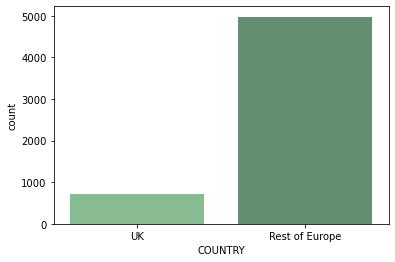

In [11]:
sns.countplot ("COUNTRY", data=df, alpha=0.8, palette="Greens_d")

QTY_COUNTRY = pd.DataFrame(df["COUNTRY"].value_counts()).reset_index()
QTY_COUNTRY

#percentage
QTY_COUNTRY['Total'] = QTY_COUNTRY['COUNTRY'].sum()
QTY_COUNTRY['Percentage'] =round(((QTY_COUNTRY['COUNTRY']/QTY_COUNTRY['Total'])*100),2)
QTY_COUNTRY

,CUSTOMER
BP,66
LIVERPOOL HOSPITAL,41
VODAFONE,36
GLASGOW BANK,33
ANGLO AMERICAN,33
GLAXOSMITHKLINE,28
RECKITT BENCKISER,25
BRITISH FOODS,23
YORK BUSINESS CENTER,17
UNILEVER,16


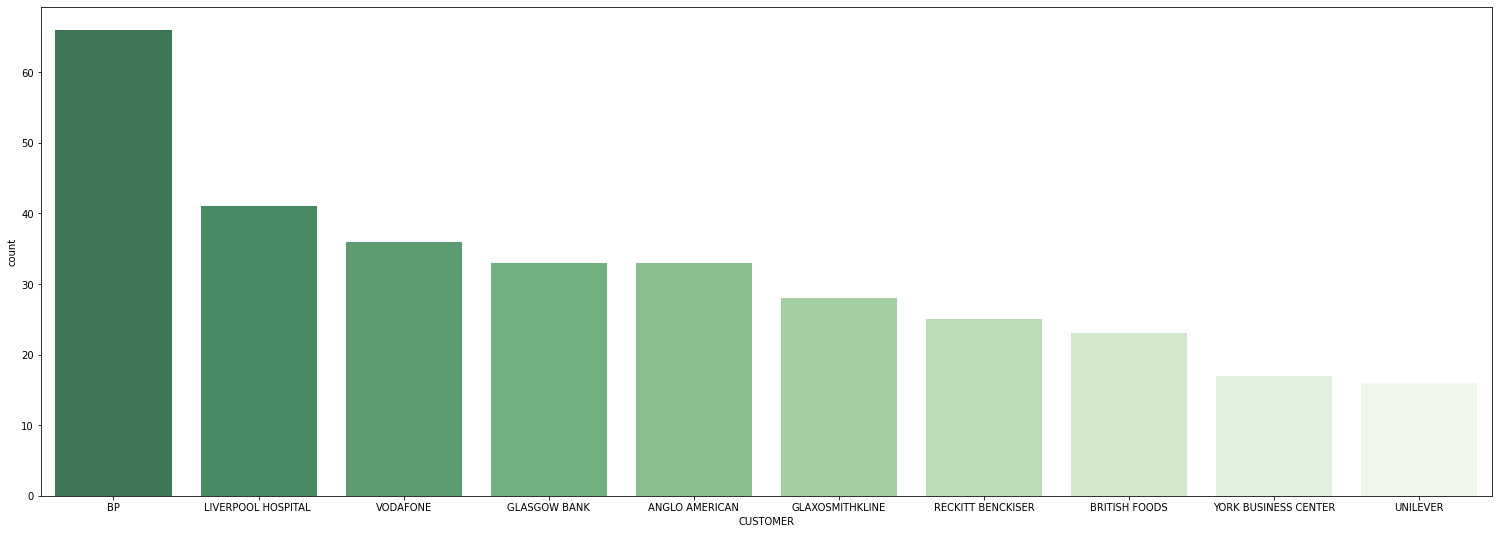

In [12]:
df = df.query("COUNTRY=='UK'").reset_index(drop=True)

plt.figure(figsize=(26,9))
sns.countplot ("CUSTOMER", data=df, alpha=0.8, palette="Greens_r", order=df.CUSTOMER.value_counts().iloc[:10].index)
QTY_CUSTOMER = pd.DataFrame(df["CUSTOMER"].value_counts())
QTY_CUSTOMER.head(10)

In [13]:
sorted_df = df.sort_values(by=['VALUE'], ascending=False)

In [14]:
sorted_df = sorted_df.head(5)

,CUSTOMER,VALUE
379,BRITISH AMERICAN TABACCO,3416000.0
236,ASTRAZENECA,1580000.0
266,AVALON DRINKS,1040000.0
655,GLAXOSMITHKLINE,960000.0
566,BARCLAYS,800000.0


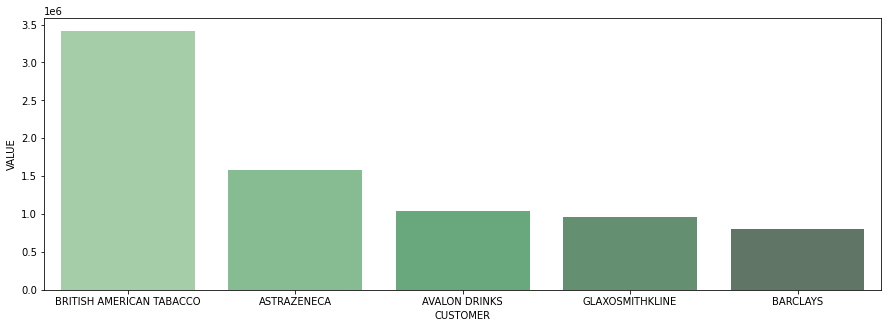

In [15]:
plt.figure(figsize=(15,5))
QTY_CUSTOMER = sorted_df[["CUSTOMER","VALUE"]]
sns.barplot (x="CUSTOMER", y="VALUE", data=QTY_CUSTOMER, alpha=0.8, palette="Greens_d", )

QTY_CUSTOMER.head(5)

### 4 - Data wrangling and RFM

In [16]:
df = df.rename(columns={'SALE_DATE': 'DATE'}) # rename column

In [17]:
df = df.query("COUNTRY=='UK'").reset_index(drop=True)
df = df.query("PRODUCT=='TECH'").reset_index(drop=True)
df_UK_TECH_region = df

### 4. 1 Recency

In [18]:
UK_TECH_region_group = pd.DataFrame(df_UK_TECH_region['CUSTOMER'].unique()) # unique to group
UK_TECH_region_group.columns = ['CUSTOMER']

In [19]:
 import datetime as datetime
today = datetime.date.today()
one_year_ago = today-datetime.timedelta(days=365)
two_year_ago = today-datetime.timedelta(days=730)

In [20]:
UK_TECH_xreg_max_purchase = df_UK_TECH_region.groupby('CUSTOMER').DATE.max().reset_index()
UK_TECH_xreg_max_purchase.columns = ['CUSTOMER','MaxPurchaseDate']

In [21]:
UK_TECH_xreg_max_purchase['MaxPurchaseDate'].dtype

dtype('O')

In [22]:
UK_TECH_xreg_max_purchase['MaxPurchaseDate'] = pd.to_datetime(UK_TECH_xreg_max_purchase['MaxPurchaseDate']).dt.date #max date

In [23]:
UK_TECH_xreg_max_purchase['Recency'] = (today - UK_TECH_xreg_max_purchase['MaxPurchaseDate']).dt.days
UK_TECH_xreg_max_purchase.head()

,CUSTOMER,MaxPurchaseDate,Recency
0,AGRI COMPANY,2019-04-30,1011
1,AI ERAZON,2021-05-14,266
2,AMAZON TABACCO,2020-12-15,416
3,AMERICAN PHARMA,2020-02-20,715
4,ANGLO AMERICAN,2020-05-30,615


In [24]:
# replacing with 0 case future recency
UK_TECH_xreg_max_purchase['Recency'] = np.where((UK_TECH_xreg_max_purchase.Recency < 0), 0,UK_TECH_xreg_max_purchase['Recency'])

In [25]:
#merge this dataframe to our new user dataframe
UK_TECH_region_group = pd.merge(UK_TECH_region_group, UK_TECH_xreg_max_purchase[['CUSTOMER','Recency']], on='CUSTOMER')

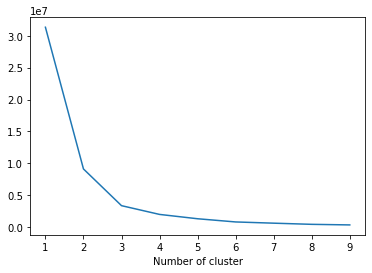

In [26]:
from sklearn.cluster import KMeans

sse={} # error
UK_TECH_xreg_recency = UK_TECH_region_group[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(UK_TECH_xreg_recency)
    UK_TECH_xreg_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [27]:
kmeans = KMeans(n_clusters=4)
UK_TECH_region_group['RecencyCluster'] = kmeans.fit_predict(UK_TECH_region_group[['Recency']])

In [28]:
UK_TECH_region_group['RecencyCluster'].value_counts()

3    30
1    29
0    25
2    23
Name: RecencyCluster, dtype: int64

In [29]:
UK_TECH_region_group.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,25.0,974.360000,115.442222,795.0,893.00,982.0,1032.00,1255.0
1,29.0,195.896552,118.361234,36.0,70.00,179.0,283.00,387.0
2,23.0,1651.217391,205.816546,1345.0,1519.50,1596.0,1748.00,2065.0
3,30.0,588.333333,108.212222,416.0,505.75,614.5,697.25,759.0


In [30]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

UK_TECH_region_group = order_cluster('RecencyCluster', 'Recency',UK_TECH_region_group,False)

In [31]:
UK_TECH_region_group.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,23.0,1651.217391,205.816546,1345.0,1519.50,1596.0,1748.00,2065.0
1,25.0,974.360000,115.442222,795.0,893.00,982.0,1032.00,1255.0
2,30.0,588.333333,108.212222,416.0,505.75,614.5,697.25,759.0
3,29.0,195.896552,118.361234,36.0,70.00,179.0,283.00,387.0


### 4.2 Frequency

In [32]:
UK_TECH_xreg_frequency = df_UK_TECH_region.groupby('CUSTOMER').SALE_ID.nunique().reset_index()
UK_TECH_xreg_frequency.columns = ['CUSTOMER','Frequency']

In [33]:
UK_TECH_region_group = pd.merge(UK_TECH_region_group, UK_TECH_xreg_frequency, on='CUSTOMER')
UK_TECH_region_group.head()

,CUSTOMER,Recency,RecencyCluster,Frequency
0,AGRI COMPANY,1011,1,2
1,LONDON COMMUNICATIONS,1162,1,1
2,INDUSTRIAL HOUSE,1038,1,1
3,VODAFONE,798,1,10
4,PORSMOUTH MINING,1129,1,2


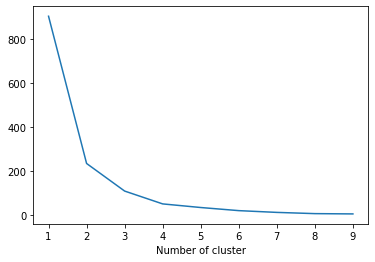

In [34]:
from sklearn.cluster import KMeans

sse={} # error
UK_TECH_xreg_recency = UK_TECH_region_group[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(UK_TECH_xreg_recency)
    UK_TECH_xreg_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [35]:
# Applying k-Means
kmeans=KMeans(n_clusters=5)
UK_TECH_region_group['FrequencyCluster']=kmeans.fit_predict(UK_TECH_region_group[['Frequency']])

#order the frequency cluster
UK_TECH_region_group = order_cluster('FrequencyCluster', 'Frequency', UK_TECH_region_group, True )
UK_TECH_region_group.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,40.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
1,36.0,2.388889,0.494413,2.0,2.00,2.0,3.00,3.0
2,18.0,4.444444,0.615699,4.0,4.00,4.0,5.00,6.0
3,9.0,8.444444,1.130388,7.0,8.00,8.0,9.00,10.0
4,4.0,13.000000,0.816497,12.0,12.75,13.0,13.25,14.0


### 4.3 Revenue

In [36]:
df_UK_TECH_region['REVENUE'] = df_UK_TECH_region['VALUE']
UK_TECH_xreg_revenue = df_UK_TECH_region.groupby('CUSTOMER').REVENUE.sum().reset_index()

In [37]:
UK_TECH_region_group = pd.merge(UK_TECH_region_group, UK_TECH_xreg_revenue, on='CUSTOMER')
UK_TECH_region_group.head()

,CUSTOMER,Recency,RecencyCluster,Frequency,FrequencyCluster,REVENUE
0,AGRI COMPANY,1011,1,2,1,17600.00
1,PORSMOUTH MINING,1129,1,2,1,20592.00
2,CAMBRIDGE UNIVERSITY,1032,1,2,1,160960.00
3,LIVERPOOL COMPANY,827,1,3,1,159065.16
4,AVALON DRINKS,1255,1,2,1,1177600.00


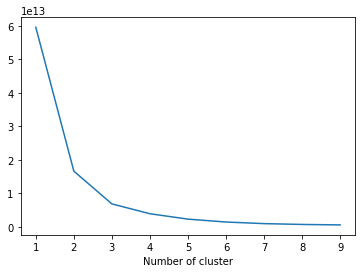

In [38]:
from sklearn.cluster import KMeans

sse={} # error
UK_TECH_xreg_recency = UK_TECH_region_group[['REVENUE']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(UK_TECH_xreg_recency)
    UK_TECH_xreg_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [39]:
#apply clustering
kmeans = KMeans(n_clusters=4)
UK_TECH_region_group['RevenueCluster'] = kmeans.fit_predict(UK_TECH_region_group[['REVENUE']])

#order the cluster numbers
UK_TECH_region_group = order_cluster('RevenueCluster', 'REVENUE',UK_TECH_region_group,True)

#show details of the dataframe
UK_TECH_region_group.groupby('RevenueCluster')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,71.0,1.052218e+05,102686.760258,1600.000,24761.600,77600.000,156525.780,425600.000
1,26.0,7.924078e+05,260305.740855,456000.000,572594.606,809120.356,1036243.506,1302534.792
2,7.0,2.072736e+06,371917.069170,1453376.544,1921101.752,2070070.384,2261754.616,2619992.568
3,3.0,3.388171e+06,612041.018331,2970578.480,3036889.240,3103200.000,3596967.592,4090735.184


### 5 - OVERALL SCORE BASE ON RFM 

In [40]:
#calculate overall score and use mean() to see details
UK_TECH_region_group['OverallScore'] = UK_TECH_region_group['RecencyCluster'] + UK_TECH_region_group['FrequencyCluster'] + UK_TECH_region_group['RevenueCluster']
UK_TECH_region_group.groupby('OverallScore')['Recency','Frequency','REVENUE'].mean()

,Recency,Frequency,REVENUE
OverallScore,,,
0,1641.071429,1.000000,6.958661e+04
1,1317.000000,1.466667,1.688621e+05
2,831.650000,1.700000,1.514699e+05
3,603.941176,2.294118,2.802172e+05
4,485.200000,3.066667,3.271199e+05
5,438.200000,4.000000,7.229300e+05
6,486.500000,7.500000,1.446032e+06
7,332.800000,7.000000,1.391201e+06
8,208.750000,10.125000,2.044927e+06


In [41]:
UK_TECH_region_group['OverallScore'].value_counts()

2    20
3    17
4    15
1    15
0    14
5    10
8     8
7     5
6     2
9     1
Name: OverallScore, dtype: int64

### 5.1 Clustering Customer Lifetime Value

In [42]:
df_UK_TECH_region["DATE"] = pd.to_datetime(df_UK_TECH_region["DATE"]).dt.date

In [43]:
UK_TECH_xreg_OneY = df_UK_TECH_region[(df_UK_TECH_region.DATE >= one_year_ago) & (df_UK_TECH_region.DATE < today)].reset_index(drop=True) #1 years time
UK_TECH_xreg_TwoY = df_UK_TECH_region[(df_UK_TECH_region.DATE >= two_year_ago) & (df_UK_TECH_region.DATE < today)].reset_index(drop=True) #2 years time

In [44]:
#calculate revenue and create a new dataframe for it
UK_TECH_xreg_OneY['Revenue'] = UK_TECH_xreg_OneY['VALUE']
UK_TECH_xreg_user_OneY = UK_TECH_xreg_OneY.groupby('CUSTOMER')['Revenue'].sum().reset_index()
UK_TECH_xreg_user_OneY.columns = ['CUSTOMER','OneY_Revenue']

In [45]:
#calculate revenue and create a new dataframe for it
UK_TECH_xreg_TwoY['Revenue'] = UK_TECH_xreg_TwoY['VALUE']
UK_TECH_xreg_user_TwoY = UK_TECH_xreg_TwoY.groupby('CUSTOMER')['Revenue'].sum().reset_index()
UK_TECH_xreg_user_TwoY.columns = ['CUSTOMER','TwoY_Revenue']

In [46]:
UK_TECH_region_group_X = pd.merge(UK_TECH_xreg_user_OneY, UK_TECH_xreg_user_TwoY, on='CUSTOMER', how='left') #Only people who are in the timeline of tx_user_1a e 2a
UK_TECH_xreg_merge = pd.merge(UK_TECH_region_group, UK_TECH_region_group_X, on='CUSTOMER', how='left') 

In [47]:
UK_TECH_xreg_final = UK_TECH_xreg_merge.fillna(0) # replacing missing value with 0

In [48]:
#remove outliers
#ent_merge = ent_merge[ent_merge['1A_Revenue']<ent_merge['1A_Revenue'].quantile(0.95)]

In [49]:
UK_TECH_xreg_final = UK_TECH_xreg_final.sort_values(by=['OverallScore','OneY_Revenue','REVENUE'], ascending=False)
UK_TECH_xreg_final = UK_TECH_xreg_final.reset_index(drop=True)

### Criando rótulos de segmentação

In [50]:
# rótulo geral
UK_TECH_xreg_final['Segment'] = '09.Dead' # condição 0
UK_TECH_xreg_final['Segment'] = np.where((UK_TECH_xreg_final.OverallScore == 1), '08.Hibertaning',UK_TECH_xreg_final['Segment'])
UK_TECH_xreg_final['Segment'] = np.where((UK_TECH_xreg_final.OverallScore == 2) & (UK_TECH_xreg_final.OneY_Revenue > 0), '06.Low Potential',UK_TECH_xreg_final['Segment'])
UK_TECH_xreg_final['Segment'] = np.where((UK_TECH_xreg_final.OverallScore == 3) & (UK_TECH_xreg_final.OneY_Revenue > 0), '06.Low Potential',UK_TECH_xreg_final['Segment'])
UK_TECH_xreg_final['Segment'] = np.where((UK_TECH_xreg_final.OverallScore == 4) & (UK_TECH_xreg_final.OneY_Revenue > 0), '06.Low Potential',UK_TECH_xreg_final['Segment'])
UK_TECH_xreg_final['Segment'] = np.where(((UK_TECH_xreg_final.OverallScore == 5) | (UK_TECH_xreg_final.OverallScore == 6)), '03.Potential Loyalty',UK_TECH_xreg_final['Segment'])
UK_TECH_xreg_final['Segment'] = np.where(((UK_TECH_xreg_final.OverallScore == 7) | (UK_TECH_xreg_final.OverallScore == 8)), '02.Loyal',UK_TECH_xreg_final['Segment'])
UK_TECH_xreg_final['Segment'] = np.where((UK_TECH_xreg_final.OverallScore == 9), '01.Champion',UK_TECH_xreg_final['Segment'])

In [51]:
Loyal = UK_TECH_xreg_final.query("Segment=='02.Loyal'").reset_index(drop=True)
Loyal['Segment'] = np.where(Loyal['OneY_Revenue'] <= Loyal.quantile(0.15)['OneY_Revenue'], '02.Loyal - Needing Attention',Loyal['Segment'])

Potencial = UK_TECH_xreg_final.query("Segment=='03.Potential Loyalty'").reset_index(drop=True)
Potencial['Segment'] = np.where(Potencial['OneY_Revenue'] <= Potencial.quantile(0.15)['OneY_Revenue'], '03.Potencial - Needing Attention',Potencial['Segment'])

# New Customer
UK_TECH_xreg_final['Segment'] = np.where(((UK_TECH_xreg_final.OverallScore == 3) |(UK_TECH_xreg_final.OverallScore == 4)) & (UK_TECH_xreg_final.OneY_Revenue == UK_TECH_xreg_final.REVENUE), '05.New Customer',UK_TECH_xreg_final['Segment'])
UK_TECH_xreg_final['Segment'] = np.where(((UK_TECH_xreg_final.OverallScore == 5)|(UK_TECH_xreg_final.OverallScore == 6)) & (UK_TECH_xreg_final.OneY_Revenue == UK_TECH_xreg_final.REVENUE), '05.New Customer',UK_TECH_xreg_final['Segment'])

Promising = UK_TECH_xreg_final.query("Segment=='05.New Customer'").reset_index(drop=True)
Promising['Segment'] = np.where(Promising['OneY_Revenue'] >= Promising.quantile(0.85)['OneY_Revenue'], '04.Promising',Promising['Segment'])

Append_df = Loyal.append(Potencial)
Append_df = Append_df.append(Promising)


In [52]:
#join and adjust
UK_TECH_xreg_final = pd.merge(UK_TECH_xreg_final, Append_df[['CUSTOMER','Segment']], on='CUSTOMER', how='left')
UK_TECH_xreg_final = UK_TECH_xreg_final.rename(columns={'Segment_x': 'Before_Segment', 'Segment_y': 'Segment' })
UK_TECH_xreg_final['Segment'] = np.where(UK_TECH_xreg_final['Segment'].isnull() , UK_TECH_xreg_final['Before_Segment'], UK_TECH_xreg_final['Segment'])
del UK_TECH_xreg_final['Before_Segment']

In [53]:
# corrigir 
UK_TECH_xreg_final['Segment'] = np.where((UK_TECH_xreg_final.OverallScore == 2) & (UK_TECH_xreg_final.OneY_Revenue == 0), '07.Sleeping',UK_TECH_xreg_final['Segment'])
UK_TECH_xreg_final['Segment'] = np.where((UK_TECH_xreg_final.OverallScore == 3) & (UK_TECH_xreg_final.OneY_Revenue == 0), '07.Sleeping',UK_TECH_xreg_final['Segment'])
UK_TECH_xreg_final['Segment'] = np.where((UK_TECH_xreg_final.OverallScore == 4) & (UK_TECH_xreg_final.OneY_Revenue == 0), '07.Sleeping',UK_TECH_xreg_final['Segment'])

### 6 - Resultados

In [54]:
#percentage
UK_TECH_xreg_perct = (pd.DataFrame(UK_TECH_xreg_final['Segment'].value_counts())).reset_index()
UK_TECH_xreg_perct['Total'] = UK_TECH_xreg_perct['Segment'].sum()
UK_TECH_xreg_perct['Percentage'] =round(((UK_TECH_xreg_perct['Segment']/UK_TECH_xreg_perct['Total'])*100),2)
UK_TECH_xreg_perct

,index,Segment,Total,Percentage
0,07.Sleeping,40,107,37.38
1,08.Hibertaning,15,107,14.02
2,09.Dead,14,107,13.08
3,02.Loyal,10,107,9.35
4,03.Potencial - Needing Attention,7,107,6.54
5,06.Low Potential,6,107,5.61
6,05.New Customer,5,107,4.67
7,03.Potential Loyalty,5,107,4.67
8,02.Loyal - Needing Attention,3,107,2.80
9,04.Promising,1,107,0.93


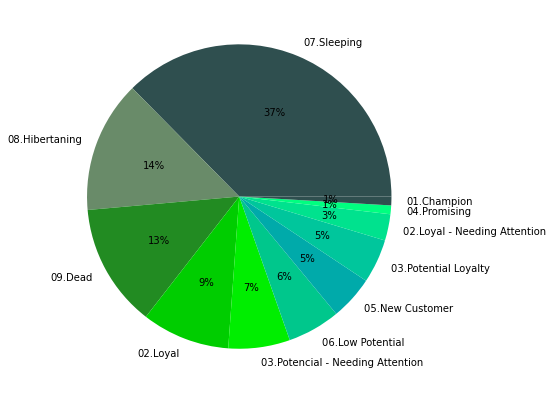

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure (figsize=(20,7))
data = UK_TECH_xreg_perct['Percentage']
labels = UK_TECH_xreg_perct['index']

#define Seaborn color palette to use
#colors = sns.color_palette('Greens_d')[0:5]
colors = ['#2F4F4F','#698B69','#228B22','#00CD00','#00EE00','#00C78C','#00AAAA','#00C69C','#00E28E','#00FF80',]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
#plt.savefig("C:\Projetos Python\TCC\plots\UK_TECH_percentage.jpg")
plt.show()

07.Sleeping                         40
08.Hibertaning                      15
09.Dead                             14
02.Loyal                            10
03.Potencial - Needing Attention     7
06.Low Potential                     6
05.New Customer                      5
03.Potential Loyalty                 5
02.Loyal - Needing Attention         3
04.Promising                         1
01.Champion                          1
Name: Segment, dtype: int64

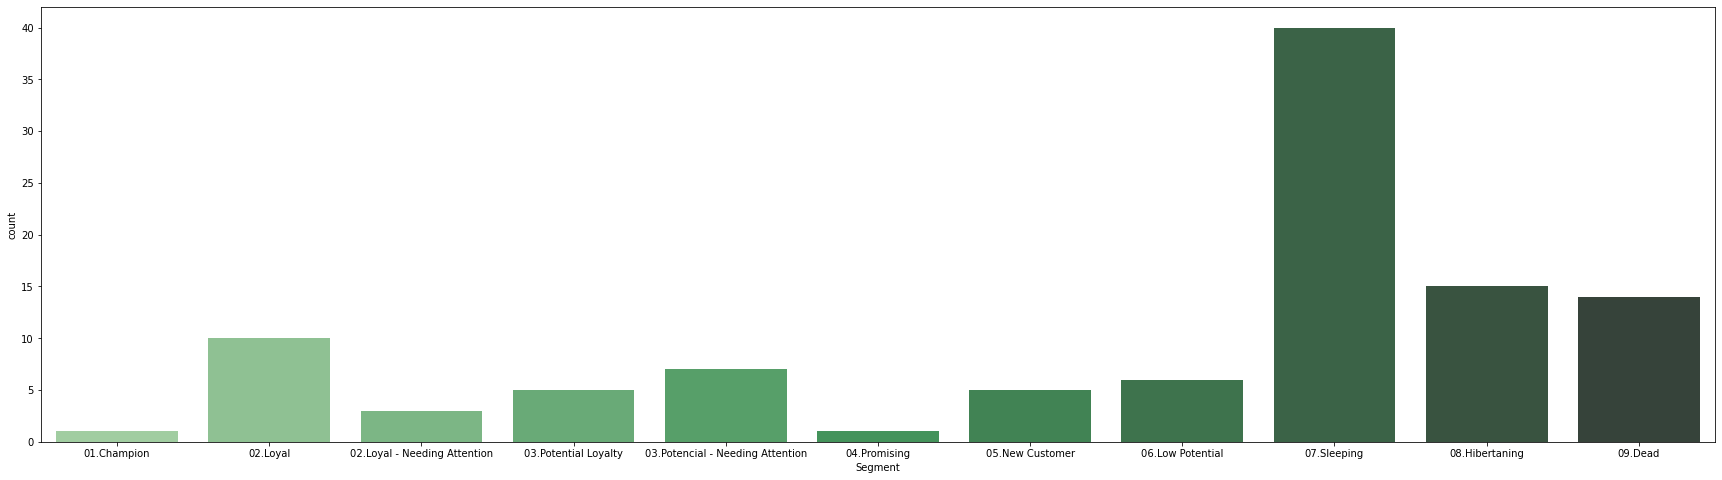

In [56]:
plt.figure (figsize=(30,8))
sns.countplot ("Segment", data=UK_TECH_xreg_final, palette="Greens_d")
UK_TECH_xreg_final['Segment'].value_counts()
#plt.savefig("C:\Projetos Python\clv\plots\UK_TECH_bar.jpg")

In [57]:
UK_TECH_xreg_final['Segment'].value_counts()

07.Sleeping                         40
08.Hibertaning                      15
09.Dead                             14
02.Loyal                            10
03.Potencial - Needing Attention     7
06.Low Potential                     6
05.New Customer                      5
03.Potential Loyalty                 5
02.Loyal - Needing Attention         3
04.Promising                         1
01.Champion                          1
Name: Segment, dtype: int64

In [69]:
UK_TECH_xreg_final.head(10)

,CUSTOMER,Recency,RecencyCluster,Frequency,FrequencyCluster,REVENUE,RevenueCluster,OverallScore,OneY_Revenue,Segment
0,UNILEVER,71,3,8,3,3103200.000,3,9,1520000.000,01.Champion
1,ASTRAZENECA,66,3,6,2,2970578.480,3,8,1580000.000,02.Loyal
2,HSBC,57,3,13,4,1302534.792,1,8,869293.872,02.Loyal
3,RIO TINTO,36,3,13,4,824581.512,1,8,581724.080,02.Loyal
4,DIAGEO,66,3,9,3,2070070.384,2,8,341431.584,02.Loyal
5,GLAXOSMITHKLINE,264,3,10,3,2619992.568,2,8,27633.224,02.Loyal
6,BRITISH AMERICAN TABACCO,179,3,4,2,4090735.184,3,8,16000.000,02.Loyal
7,ANGLO AMERICAN,615,2,12,4,1453376.544,2,8,0.000,02.Loyal - Needing Attention
8,BP,387,3,14,4,1027549.224,1,8,0.000,02.Loyal - Needing Attention
9,ROYAL DUTCH SHELL,343,3,7,3,1071352.736,1,7,612000.000,02.Loyal


In [58]:
UK_TECH_xreg_final.to_excel(r'C:\Projetos Python\TCC\Output\\CLUSTER_UK_TECH.xlsx', sheet_name='UK_TECH', index = False)

In [59]:
print('END')

END
